In [ ]:
!pip install faker pandas

In [ ]:
!pip install reportlab

In [ ]:
!pip install transformers
!pip install torch

In [ ]:
!pip install PyPDF2 sentence-transformers scikit-learn pandas

In [ ]:
import pandas as pd
from google.colab import files
import os
from reportlab.lib.pagesizes import A4
from datetime import datetime, timedelta
from reportlab.pdfgen import canvas
import os
import hashlib

In [ ]:
import random
from faker import Faker
import pandas as pd

fake = Faker()
Faker.seed(42)
random.seed(42)

# Add provinces and formatting rules
provinces = ['Ontario', 'British Columbia', 'Alberta']

def generate_healthcard(province):
    if province == 'Ontario':
        return ''.join([str(random.randint(0, 9)) for _ in range(10)])
    elif province == 'British Columbia':
        return '9' + ''.join([str(random.randint(0, 9)) for _ in range(9)])  # PHN starts with 9
    elif province == 'Alberta':
        return ''.join([str(random.randint(0, 9)) for _ in range(9)])  # ULI is 9 digits

def generate_postal_code(province):
    if province == 'Ontario':
        start = 'M'  # Toronto area
    elif province == 'British Columbia':
        start = 'V'  # Vancouver area
    elif province == 'Alberta':
        start = 'T'  # Calgary area
    return f"{start}{random.randint(1, 9)}{random.choice('ABCDEFGHIJKLMNOPQRSTUVWXYZ')} {random.randint(1, 9)}{random.choice('ABCDEFGHIJKLMNOPQRSTUVWXYZ')}{random.randint(1, 9)}"

def enforce_test_if_needed(symptoms, dept, current_test):
    high_risk_symptoms = {
        'Ultrasound': ['abdominal pain', 'liver tenderness', 'kidney pain'],
        'Cardiology': ['chest pain', 'palpitations', 'shortness of breath'],
        'Neurology': ['memory loss', 'blurred vision', 'dizziness'],
        'Dermatology': ['skin discoloration'],
        'Psychiatry': ['panic attacks', 'depression'],
        'ENT': ['hearing loss', 'blocked nose', 'tinnitus'],
        'Oncology': ['lump in breast', 'unexplained weight loss', 'bone pain']
    }

    high_risk = high_risk_symptoms.get(dept, [])
    if any(sym in high_risk for sym in symptoms):
        # If current test is missing or inappropriate, assign first available
        valid_tests = department_data[dept]['test_type']
        if current_test == 'Not Applicable' or current_test not in valid_tests:
            return valid_tests[0]
    return current_test

# Urgent test types
urgent_tests = ['CT', 'MRI', 'Biopsy']

def determine_urgency(symptoms, test_type, dept, urgency_ratio=0.5):
    high_risk_symptoms = {
        'Cardiology': ['chest pain', 'palpitations', 'shortness of breath'],
        'Neurology': ['memory loss', 'blurred vision', 'dizziness'],
        'Dermatology': ['skin discoloration'],
        'Psychiatry': ['panic attacks', 'depression'],
        'ENT': ['hearing loss', 'blocked nose', 'tinnitus'],
        'Ultrasound': ['abdominal pain', 'liver tenderness'],
        'Oncology': ['lump in breast', 'unexplained weight loss', 'bone pain']
    }

    urgent_tests = ['CT', 'MRI', 'Biopsy']

    # Normalize input to lowercase for consistent matching
    symptoms_lower = [s.lower() for s in symptoms]
    dept_high_risk = [s.lower() for s in high_risk_symptoms.get(dept, [])]
    test_type_upper = test_type.upper()

    # If any symptom is high risk or test is urgent, return Urgent immediately
    if any(symptom in dept_high_risk for symptom in symptoms_lower) or test_type_upper in urgent_tests:
        return 'Urgent'

    # Default to routine
    return 'Routine'

departments = ['Cardiology', 'Neurology', 'Dermatology', 'Psychiatry', 'ENT', 'Ultrasound', 'Oncology']

department_data = {
    'Cardiology': {
        'symptoms': ['chest pain', 'shortness of breath', 'palpitations', 'fatigue', 'irregular heartbeat',
                     'mild dizziness', 'occasional palpitations', 'slight swelling'],
        'routine_symptoms': ['mild dizziness', 'occasional palpitations', 'slight swelling'],
        'summary': 'Patient experiences {}. ECG suggests arrhythmia. BP elevated. Possible cardiac issue.',
        'test_type': ['ECG', 'Echocardiogram', 'CT', 'Not Applicable']
    },
    'Neurology': {
        'symptoms': ['headache', 'dizziness', 'numbness in limbs', 'memory loss', 'blurred vision',
                     'occasional headaches', 'mild numbness'],
        'routine_symptoms': ['occasional headaches', 'mild numbness'],
        'summary': 'Reports {}. MRI shows mild abnormalities. Suspected neurological involvement.',
        'test_type': ['MRI', 'CT', 'Not Applicable']
    },
    'Dermatology': {
        'symptoms': ['rash', 'itching', 'skin discoloration', 'dry skin', 'peeling',
                     'mild rash', 'dry skin patches'],
        'routine_symptoms': ['mild rash', 'dry skin patches'],
        'summary': 'Observed {}. Suspect dermatitis or allergy.',
        'test_type': ['Skin Biopsy', 'Not Applicable']
    },
    'Psychiatry': {
        'symptoms': ['anxiety', 'insomnia', 'depression', 'panic attacks', 'mood swings',
                     'stress', 'mild anxiety'],
        'routine_symptoms': ['stress', 'mild anxiety'],
        'summary': 'Exhibits signs of {}. Referred for further psychiatric evaluation.',
        'test_type': ['Not Applicable']
    },
    'ENT': {
        'symptoms': ['hearing loss', 'earache', 'sore throat', 'blocked nose', 'tinnitus',
                     'occasional sore throat', 'mild nasal congestion'],
        'routine_symptoms': ['occasional sore throat', 'mild nasal congestion'],
        'summary': '{} for 2 weeks. ENT exam recommended.',
        'test_type': ['Audiometry', 'X-Ray', 'Not Applicable']
    },
    'Ultrasound': {
        'symptoms': ['abdominal pain', 'pelvic discomfort', 'liver tenderness', 'kidney pain',
                     'mild pelvic discomfort'],
        'routine_symptoms': ['mild pelvic discomfort'],
        'summary': 'Complains of {}. Ultrasound advised for abdominal scan.',
        'test_type': ['Ultrasound']
    },
    'Oncology': {
        'symptoms': ['lump in breast', 'unexplained weight loss', 'persistent fatigue', 'bone pain',
                     'occasional fatigue'],
        'routine_symptoms': ['occasional fatigue'],
        'summary': '{} observed. Biopsy recommended. Possible malignancy.',
        'test_type': ['CT', 'MRI', 'Biopsy']
    }
}

medications_list = [
    'Metformin', 'Lisinopril', 'Atorvastatin', 'Amlodipine', 'Albuterol', 'Levothyroxine',
    'Ibuprofen', 'Omeprazole', 'Hydrochlorothiazide', 'Losartan', 'Amoxicillin', 'Sertraline'
]

allergies_list = [
    'Penicillin', 'Pollen', 'Dust mites', 'Bee stings', 'Peanuts', 'Shellfish',
    'Latex', 'Cats', 'Mold', 'Aspirin'
]

care_plans = [
    'Follow-up in 2 weeks', 'Surgery scheduled', 'Prescribed medication',
    'Advised physiotherapy', 'Mental health counseling', 'Radiation therapy scheduled',
    'Lifestyle modifications advised'
]

occupations = [
    'Software Engineer', 'Construction Worker', 'Teacher', 'Driver', 'Nurse', 'Cashier',
    'Electrician', 'Office Assistant', 'Mechanic', 'Data Analyst', 'Athlete', 'Warehouse Worker',
    'Waiter', 'Student', 'Retired', 'Architect', 'Accountant', 'Social Worker', 'Chef',
    'Musician', 'Police Officer', 'Firefighter', 'Delivery Driver', 'Fitness Trainer', 'Photographer',
    'Journalist', 'Graphic Designer', 'Assembly Line Worker', 'Farmer', 'Lawyer', 'Writer'
]

test_results_choices = ['Pending', 'Completed']
past_treatments = [
    'Appendectomy', 'Knee surgery', 'Heart bypass', 'Gallbladder removal',
    'None', 'Tonsillectomy', 'Back surgery', 'Fracture repair', 'Migraine treatment', 'Chemotherapy'
]

medical_history_list = [
    'Appendectomy', 'Knee surgery', 'Heart bypass', 'Gallbladder removal',
    'Family history of diabetes', 'Family history of heart disease',
    'Family history of cancer', 'Migraine treatment', 'Chemotherapy',
    'No significant history'
]

# Step 1: Add referral reasons per department
referral_reasons = {
    'Cardiology': [
        "Evaluate chest pain and assess cardiac function",
        "Review ECG abnormalities and rule out arrhythmia",
        "Assess shortness of breath for possible heart failure"
    ],
    'Neurology': [
        "Investigate recurring headaches and memory issues",
        "Assess suspected neurological disorder",
        "Referral for dizziness and possible seizure activity"
    ],
    'Dermatology': [
        "Evaluate persistent rash and possible allergic reaction",
        "Assess skin discoloration for dermatological diagnosis",
        "Referral for chronic eczema or dermatitis"
    ],
    'Psychiatry': [
        "Assess depressive symptoms and provide psychiatric care",
        "Referral for mood swings and panic attacks",
        "Evaluate anxiety and sleep disturbances"
    ],
    'ENT': [
        "Evaluate chronic sore throat and ear pain",
        "Investigate hearing loss and blocked nose",
        "Referral for persistent tinnitus"
    ],
    'Ultrasound': [
        "Assess abdominal pain via ultrasound imaging",
        "Investigate pelvic discomfort with ultrasound",
        "Referral for liver tenderness evaluation"
    ],
    'Oncology': [
        "Evaluate abnormal biopsy and rule out malignancy",
        "Referral for unexplained weight loss and fatigue",
        "Assess suspicious lump for cancer screening"
    ]
}

records = []

for _ in range(500):
    dob = fake.date_of_birth(minimum_age=18, maximum_age=90)
    age = (pd.Timestamp.now().year - dob.year)
    dept = random.choice(departments)
    symptoms = random.sample(department_data[dept]['symptoms'], k=random.randint(2, 3))
    summary = department_data[dept]['summary'].format(", ".join(symptoms))
    available_tests = department_data[dept]['test_type']
    test_type = random.choice(available_tests)
    test_type = enforce_test_if_needed(symptoms, dept, test_type)
    test_result = random.choice(test_results_choices) if test_type != 'Not Applicable' else 'Not Needed'
    medications = random.sample(medications_list, k=random.randint(1, 2))
    allergies = random.sample(allergies_list, k=random.randint(0, 2))
    reason_for_referral = random.choice(referral_reasons[dept])
    province = random.choice(provinces)
    postal_code = generate_postal_code(province)
    healthcard_number = generate_healthcard(province)
    urgency = determine_urgency(symptoms, test_type, dept)

    record = {
        'Name': fake.name(),
        'DOB': dob.strftime('%Y-%m-%d'),
        'Age': age,
        'Gender': random.choice(['Male', 'Female']),
        'Occupation': random.choice(occupations),
        'Phone Number': "'" + f"+1-{random.randint(100,999):03}-{random.randint(100,999):03}-{random.randint(1000,9999):04}",
        'Address': f"{fake.street_address()}, {fake.city()}, {province}, {postal_code}",
        'HealthCard Number': healthcard_number,
        'Province': province,
        'Postal Code': postal_code,
        'Blood Type': random.choice(['A+', 'A-', 'B+', 'B-', 'AB+', 'AB-', 'O+', 'O-']),
        'Medical Condition': f'Potential {dept} issue',
        'Symptoms': ", ".join(symptoms),
        'Medications': ", ".join(medications),
        'Allergies': ", ".join(allergies) if allergies else 'None',
        'Medical History': random.choice(medical_history_list),
        'Test Type': test_type,
        'Test Results': test_result,
        'Reason for Referral': reason_for_referral,
        'Care Plan': random.choice(care_plans),
        'Doctor': fake.name(),
        'Urgency': urgency,
        'Clinical Summary': summary,
    }

    records.append(record)

df = pd.DataFrame(records)
print(df.columns)
df.head()

Index(['Name', 'DOB', 'Age', 'Gender', 'Occupation', 'Phone Number', 'Address',
       'HealthCard Number', 'Province', 'Postal Code', 'Blood Type',
       'Medical Condition', 'Symptoms', 'Medications', 'Allergies',
       'Medical History', 'Test Type', 'Test Results', 'Reason for Referral',
       'Care Plan', 'Doctor', 'Urgency', 'Clinical Summary'],
      dtype='object')


,Name,DOB,Age,Gender,Occupation,Phone Number,Address,HealthCard Number,Province,Postal Code,...,Medications,Allergies,Medical History,Test Type,Test Results,Reason for Referral,Care Plan,Doctor,Urgency,Clinical Summary
0,Donald Walker,1981-01-30,44,Female,Office Assistant,'+1-559-703-5557,"819 Johnson Course, East William, Alberta, T9C...",133890838,Alberta,T9C 7B1,...,Sertraline,None,Heart bypass,Ultrasound,Pending,Referral for liver tenderness evaluation,Radiation therapy scheduled,Cristian Santos,Urgent,"Complains of abdominal pain, liver tenderness...."
1,Kevin Pacheco,1974-03-08,51,Male,Delivery Driver,'+1-171-146-4733,"65423 Garcia Light, West Melanieview, British ...",9816184959,British Columbia,V5Z 1X8,...,Lisinopril,Pollen,Knee surgery,Not Applicable,Not Needed,Referral for mood swings and panic attacks,Lifestyle modifications advised,Monica Herrera,Urgent,"Exhibits signs of depression, insomnia, stress..."
2,Juan Calderon,2005-06-10,20,Male,Journalist,'+1-423-510-5386,"310 Kendra Common Apt. 164, Reidstad, British ...",9276483503,British Columbia,V2T 3R4,...,Levothyroxine,Bee stings,Gallbladder removal,CT,Completed,Referral for dizziness and possible seizure ac...,Mental health counseling,Henry Santiago,Urgent,"Reports memory loss, numbness in limbs. MRI sh..."
3,Andrea Reid,1985-08-20,40,Male,Waiter,'+1-490-710-8668,"76483 Cameron Trail, East Lydiamouth, Alberta,...",287101226,Alberta,T7S 7L4,...,"Atorvastatin, Amlodipine","Mold, Aspirin",Chemotherapy,Ultrasound,Pending,Investigate pelvic discomfort with ultrasound,Lifestyle modifications advised,Austin Gentry,Routine,"Complains of pelvic discomfort, kidney pain, m..."
4,Christy Porter,1975-10-22,50,Male,Musician,'+1-431-600-1319,"42388 Burgess Meadow Suite 532, Daviston, Albe...",489325288,Alberta,T5Q 3Q2,...,"Ibuprofen, Atorvastatin",Penicillin,Family history of heart disease,CT,Pending,Assess shortness of breath for possible heart ...,Lifestyle modifications advised,Brittany Moore,Urgent,"Patient experiences irregular heartbeat, occas..."


In [ ]:
# Save to CSV
print("Columns right before saving to CSV:", df.columns.tolist())
df.to_csv("synthetic_generated.csv", index=False)
files.download("synthetic_generated.csv")

Columns right before saving to CSV: ['Name', 'DOB', 'Age', 'Gender', 'Occupation', 'Phone Number', 'Address', 'HealthCard Number', 'Province', 'Postal Code', 'Blood Type', 'Medical Condition', 'Symptoms', 'Medications', 'Allergies', 'Medical History', 'Test Type', 'Test Results', 'Reason for Referral', 'Care Plan', 'Doctor', 'Urgency', 'Clinical Summary']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import hashlib
import os
from datetime import datetime
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas
from reportlab.lib.utils import simpleSplit
from reportlab.lib import colors

def create_referral_pdf(data, filepath, referral_id, referral_date):
    width, height = A4
    x_margin = 50
    y_start = height - 70
    line_height = 18
    right_column_x = 320
    c = canvas.Canvas(filepath, pagesize=A4)
    c.setStrokeColor(colors.green)

    # Header: Ontario Health Home (left, bigger) and Address (right)
    ontario_health_text = "Ontario Health Home"
    address_text = "1 King St, Toronto, ON, M1N 2P3"
    logo_path = "/content/logo.png"

    # Draw the image: (x, y, width, height)
    c.drawImage(logo_path, x=48, y=800, width=140, height=25)

    # Ontario Health Home - Bigger and on the left
    #c.setFont("Helvetica-Bold", 16)
    #c.drawString(x_margin, height - 40, ontario_health_text)

    # Address - smaller, on the right
    c.setFont("Helvetica", 10)
    address_width = c.stringWidth(address_text, "Helvetica", 10)
    c.drawString(width - 200, height - 40, address_text)

    # Title centered
    c.setFont("Helvetica-Bold", 16)
    title = "Patient Referral Document"
    title_width = c.stringWidth(title, "Helvetica-Bold", 16)

    # Center title *between margins*, not full page width
    title_x = x_margin + (width - 2 * x_margin - title_width) / 2
    c.drawString(title_x, y_start, title)

    y = y_start - 15

    # Horizontal line below title
    c.setStrokeColor(colors.green)
    c.setLineWidth(1)
    #c.line(x_margin, y, width - x_margin, y)
    y -= 20

    # Patient Information Header
    c.setFont("Helvetica-Bold", 13)
    c.setFillColor(colors.green)
    c.drawString(x_margin, y, "Patient Information")
    y -= 20
    c.setFont("Helvetica", 11)
    c.setFillColor(colors.black)
    c.setStrokeColor(colors.black)

    # Helper function to draw label and value with line, side by side
    def draw_label_and_line(label, value, x_label, x_line, y_pos, line_length=100):
        c.setFont("Helvetica", 11)
        # Draw label + colon
        c.drawString(x_label, y_pos, f"{label}:")
        # Draw value above line, a bit to the right
        c.drawString(x_line, y_pos, str(value))
        # Draw underline below the value
        line_y = y_pos - 3
        c.line(x_line, line_y, x_line + line_length, line_y)

    # Patient Information Header
    c.setFont("Helvetica-Bold", 16)
    title = "Patient Referral Document"
    title_width = c.stringWidth(title, "Helvetica-Bold", 16)
    line_y_top = y_start + 25
    c.setLineWidth(1)
    c.setStrokeColor(colors.green)
    c.line(x_margin, line_y_top, width - x_margin, line_y_top)
    c.setStrokeColor(colors.black)

    # Layout constants
    left_col_x = x_margin
    right_col_x = right_column_x
    line_spacing = 22
    underline_length = 140
    long_underline_length = 150
    label_width_fixed = 85

    # Helper to draw label + aligned underline + value on top
    def draw_label_value_block(label, value, x, y_pos, is_long=False):
      c.setFont("Helvetica", 11)
      c.drawString(x, y_pos, f"{label}:")
      underline_start = x + label_width_fixed
      value_str = str(value)

      # Calculate text width for value string
      text_width = c.stringWidth(value_str, "Helvetica", 11)
      padding = 10  # pixels padding after the value text

      # Adjust underline length: longer for 'is_long' fields like Address
      if is_long:
        line_length = 410 #max(text_width + padding, long_underline_length)
      else:
        line_length = max(text_width + padding, underline_length)

      display_value = value_str

      c.drawString(underline_start, y_pos, display_value)
      c.line(underline_start, y_pos - 3, underline_start + line_length, y_pos - 3)

    # Patient Info fields
    patient_left = [
        ("Referral ID", referral_id),
        ("Referral Date", referral_date),
        ("Name", data["Name"]),
        ("Date of Birth", data.get("DOB", "N/A")),
        ("Phone Number", str(data["Phone Number"]).replace("'", "")),
        ("Address", data["Address"]),
    ]

    patient_right = [
        ("HealthCard", data["HealthCard Number"]),
        ("Blood Type", data["Blood Type"]),
        ("Occupation", data["Occupation"]),
        ("Age", data["Age"]),
        ("Gender", data["Gender"]),
    ]

    # Draw fields aligned
    for i in range(max(len(patient_left), len(patient_right))):
        y_pos = y - i * line_spacing
        if i < len(patient_left):
            label, value = patient_left[i]
            draw_label_value_block(label, value, left_col_x, y_pos, is_long=(label == "Address"))
        if i < len(patient_right):
            label, value = patient_right[i]
            draw_label_value_block(label, value, right_col_x, y_pos)

    y -= (max(len(patient_left), len(patient_right)) * line_spacing) + 20

    # Horizontal line before Medical Information
    c.setLineWidth(1)
    c.line(x_margin, y, width - x_margin, y)
    y -= 20

    # Medical Information Header
    c.setFont("Helvetica-Bold", 13)
    c.setFillColor(colors.green)
    c.drawString(x_margin, y, "Medical Information")
    y -= 20
    c.setFillColor(colors.black)
    c.setFont("Helvetica", 11)

    medical_fields = [
        ("Medical Condition", data["Medical Condition"]),
        ("Symptoms", data["Symptoms"]),
        ("Medical History", data["Medical History"]),
        ("Medications", data["Medications"]),
        ("Allergies", data["Allergies"]),
        ("Test Type", data.get("Test Type", "Not Applicable")),
        ("Test Results", data["Test Results"]),
        ("Reason for Referral", data.get("Reason for Referral", "Not specified")),
        ("Care Plan", data["Care Plan"]),
        ("Doctor", data["Doctor"]),
        ("Urgency", data["Urgency"])
    ]

    for label, value in medical_fields:
    # Check if there's enough space for 3 lines (label + some value lines + margin)
      min_lines_needed = 3
      if y < 60 + (min_lines_needed * line_height):
        c.showPage()
        y = height - 50
        c.setFont("Helvetica-Bold", 13)
        c.drawString(x_margin, y, "Medical Information (cont.)")
        y -= 25
        c.setLineWidth(0.5)
        c.line(x_margin, y, width - x_margin, y)
        y -= 30
        c.setFont("Helvetica", 11)

      wrapped_lines = simpleSplit(f"{value}", "Helvetica", 11, width - 2 * x_margin)
      draw_label_and_line(label, wrapped_lines[0], x_margin, x_margin + 150, y,line_length=300)
      y -= line_height
      for line in wrapped_lines[1:]:
        if y < 60:
            c.showPage()
            y = height - 50
            c.setFont("Helvetica", 11)
        c.drawString(x_margin, y, line)
        y -= line_height
      y -= 10


    # Horizontal line before Clinical Summary
    y -= 10
    c.setLineWidth(1)
    c.line(x_margin, y, width - x_margin, y)
    y -= 20

    # Clinical Summary Header
    c.setFont("Helvetica-Bold", 13)
    c.setFillColor(colors.green)
    c.drawString(x_margin, y, "Clinical Summary")
    y -= 20
    c.setFont("Helvetica", 11)
    c.setFillColor(colors.black)

    summary_lines = simpleSplit(data["Clinical Summary"], "Helvetica", 11, width - 2 * x_margin)
    for line in summary_lines:
        c.drawString(x_margin, y, line)
        y -= line_height
        if y < 60:
            c.showPage()
            y = height - 50
            c.setFont("Helvetica", 11)

    c.save()


# Main code to generate files
import pandas as pd

df = pd.read_csv("synthetic_generated.csv")

output_folder = "form_referrals"
os.makedirs(output_folder, exist_ok=True)  # Create folder if it doesn't exist

for idx, row in df.head(500).iterrows():
    # Create a unique referral id
    data_str = f"{row['Name']}_{row.get('DOB', 'N/A')}_{datetime.now().isoformat()}"
    referral_id = "REF-" + hashlib.md5(data_str.encode()).hexdigest()[:8]
    referral_date = datetime.today().strftime("%Y-%m-%d")

    full_name = row.get("Name", "").strip()
    if " " in full_name:
      first_name, _ = full_name.split(" ", 1)
    else:
      first_name = full_name

    first_part = first_name[:4].lower() if first_name else "anon"

    healthcard = str(row.get("HealthCard Number", "0000")).strip()
    last_part = healthcard[-4:] if healthcard.isdigit() or healthcard[-4:].isdigit() else "0000"

    filename = f"referral_{first_part}_{last_part}.pdf"

    # Save directory and full path
    save_dir = "./referrals_forms"
    os.makedirs(save_dir, exist_ok=True)
    filepath = os.path.join(save_dir, filename)
    #filepath = os.path.join(output_folder, filename)
    create_referral_pdf(row, filepath, referral_id, referral_date)

print(f"Generated {min(len(df), 500)} referral PDFs in '{output_folder}'")

Generated 500 referral PDFs in 'form_referrals'


In [ ]:
#from google.colab import files
#files.download("referrals")

In [ ]:
import os

# Folder where PDFs are saved
output_folder = "referrals_forms"

# List PDF files
pdf_files = sorted(os.listdir(output_folder))

# Get the first one
first_pdf_path = os.path.join(output_folder, pdf_files[10])
print(first_pdf_path)


referrals_forms/referral_alys_5290.pdf


In [ ]:
from google.colab import files

files.download(first_pdf_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from PyPDF2 import PdfReader

# Step 1: Extract structured data from PDF files
def extract_fields_from_pdf(pdf_path):
    reader = PdfReader(pdf_path)
    text = ''
    for page in reader.pages:
        text += page.extract_text() + '\n'

    # Use regex or simple string search to extract fields
    fields = {
        'Reason for Referral': '',
        'Medical Condition': '',
        'Symptoms': '',
        'Urgency': '',
    }

    for key in fields.keys():
        match = re.search(rf'{key}:\s*(.*)', text)
        if match:
            fields[key] = match.group(1).strip()

    return fields

# Step 2: Build dataset from PDF folder
data = []
pdf_dir = 'referrals_forms'

for filename in os.listdir(pdf_dir):
    if filename.endswith('.pdf'):
        pdf_path = os.path.join(pdf_dir, filename)
        fields = extract_fields_from_pdf(pdf_path)
        data.append(fields)

# Create DataFrame
df = pd.DataFrame(data)
print("Columns in DataFrame:", df.columns.tolist())

# Drop rows with missing urgency (required for label)
df.dropna(subset=['Urgency'], inplace=True)

# Step 3: Combine relevant columns for text feature
df['combined_text'] = (
    df['Reason for Referral'].fillna('') + ' ' +
    df['Medical Condition'].fillna('') + ' ' +
    df['Symptoms'].fillna('')
)

# Step 4: Set up features and labels
X = df['combined_text']
y = df['Urgency']

# Optional: check label distribution
print("Label Distribution:\n", y.value_counts())

# Step 5: Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 6: TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Step 7: Train classifier
clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(X_train_vec, y_train)

# Step 8: Predict and evaluate
y_pred = clf.predict(X_test_vec)
print("\nLogistic Regression with TF-IDF Classification Report:\n")
print(classification_report(y_test, y_pred))

from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# After model predicts
y_pred = clf.predict(X_test_vec)

# Get report as dict
report = classification_report(y_test, y_pred, output_dict=True)
accuracy = accuracy_score(y_test, y_pred)

# Extract metrics for "Urgent" class
model_metrics = {
    'Model': 'Logistic Regression (TF-IDF)',
    'Precision (Urgent)': report.get('Urgent', {}).get('precision', 0),
    'Recall (Urgent)': report.get('Urgent', {}).get('recall', 0),
    'F1-Score (Urgent)': report.get('Urgent', {}).get('f1-score', 0),
    'Accuracy': accuracy
}

# Save or append to CSV or list
df_metrics = pd.DataFrame([model_metrics])
df_metrics.to_csv('metrics_summary.csv', mode='a', header=not os.path.exists('metrics_summary.csv'), index=False)


Columns in DataFrame: ['Reason for Referral', 'Medical Condition', 'Symptoms', 'Urgency']
Label Distribution:
 Urgency
Urgent     371
Routine    129
Name: count, dtype: int64

Logistic Regression with TF-IDF Classification Report:

              precision    recall  f1-score   support

     Routine       0.59      0.73      0.66        26
      Urgent       0.90      0.82      0.86        74

    accuracy                           0.80       100
   macro avg       0.75      0.78      0.76       100
weighted avg       0.82      0.80      0.81       100



In [ ]:
import os
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from PyPDF2 import PdfReader
from sentence_transformers import SentenceTransformer

# 1. Extract fields from a single PDF
def extract_fields_from_pdf(pdf_path):
    reader = PdfReader(pdf_path)
    text = ''
    for page in reader.pages:
        text += page.extract_text() + '\n'

    fields = {
        'Reason for Referral': '',
        'Medical Condition': '',
        'Symptoms': '',
        'Urgency': '',
    }

    for key in fields:
        match = re.search(rf'{key}:\s*(.*)', text)
        if match:
            fields[key] = match.group(1).strip()

    return fields

# 2. Process all PDFs in the folder
pdf_dir = 'referrals_forms'
data = []

for filename in os.listdir(pdf_dir):
    if filename.endswith('.pdf'):
        path = os.path.join(pdf_dir, filename)
        fields = extract_fields_from_pdf(path)
        data.append(fields)

df = pd.DataFrame(data)

# Drop rows with missing urgency
df.dropna(subset=['Urgency'], inplace=True)

# 3. Combine text columns
df['combined_text'] = (
    df['Reason for Referral'].fillna('') + ' ' +
    df['Medical Condition'].fillna('') + ' ' +
    df['Symptoms'].fillna('')
)

# 4. Features and labels
X = df['combined_text']
y = df['Urgency']

print("Label Distribution:\n", y.value_counts())

# 5. Train/test split
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 6. SBERT embedding
model = SentenceTransformer('all-MiniLM-L6-v2')
X_train_emb = model.encode(X_train_text.tolist(), show_progress_bar=True)
X_test_emb = model.encode(X_test_text.tolist(), show_progress_bar=True)

# 7. Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_emb, y_train)

# 8. Evaluate
y_pred = clf.predict(X_test_emb)
print("\nRandom Forest Classification Report:\n")
print(classification_report(y_test, y_pred))

from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# After model predicts
y_pred = clf.predict(X_test_emb)

# Get report as dict
report = classification_report(y_test, y_pred, output_dict=True)
accuracy = accuracy_score(y_test, y_pred)

# Extract metrics for "Urgent" class
model_metrics = {
    'Model': 'Random Forest (SBERT)',
    'Precision (Urgent)': report.get('Urgent', {}).get('precision', 0),
    'Recall (Urgent)': report.get('Urgent', {}).get('recall', 0),
    'F1-Score (Urgent)': report.get('Urgent', {}).get('f1-score', 0),
    'Accuracy': accuracy
}

# Save or append to CSV or list
df_metrics = pd.DataFrame([model_metrics])
df_metrics.to_csv('metrics_summary.csv', mode='a', header=not os.path.exists('metrics_summary.csv'), index=False)


Label Distribution:
 Urgency
Urgent     371
Routine    129
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]


Random Forest Classification Report:

              precision    recall  f1-score   support

     Routine       0.89      0.62      0.73        26
      Urgent       0.88      0.97      0.92        74

    accuracy                           0.88       100
   macro avg       0.88      0.79      0.83       100
weighted avg       0.88      0.88      0.87       100



In [ ]:
import os
import re
import pandas as pd
from PyPDF2 import PdfReader
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

# 1. Extract fields from each PDF
def extract_fields_from_pdf(pdf_path):
    reader = PdfReader(pdf_path)
    text = ''
    for page in reader.pages:
        text += page.extract_text() + '\n'

    fields = {
        'Reason for Referral': '',
        'Medical Condition': '',
        'Symptoms': '',
        'Urgency': '',
    }

    for key in fields:
        match = re.search(rf'{key}:\s*(.*)', text)
        if match:
            fields[key] = match.group(1).strip()

    return fields

# 2. Read PDFs from directory
pdf_dir = 'referrals_forms'
data = []

for filename in os.listdir(pdf_dir):
    if filename.endswith('.pdf'):
        path = os.path.join(pdf_dir, filename)
        fields = extract_fields_from_pdf(path)
        data.append(fields)

# 3. Create DataFrame
df = pd.DataFrame(data)

# Drop rows with missing labels
df.dropna(subset=['Urgency'], inplace=True)

# 4. Combine text fields
df['combined_text'] = (
    df['Reason for Referral'].fillna('') + ' ' +
    df['Medical Condition'].fillna('') + ' ' +
    df['Symptoms'].fillna('')
)

# 5. Define features and labels
X = df['combined_text']
y = df['Urgency']

# 6. Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 7. Generate sentence embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
X_train_embedded = model.encode(X_train.tolist(), convert_to_numpy=True)
X_test_embedded = model.encode(X_test.tolist(), convert_to_numpy=True)

# 8. Apply SMOTE on training embeddings
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_embedded, y_train)

# Print balanced class distribution after SMOTE
print("\nBalanced class distribution after SMOTE:\n")
print(pd.Series(y_train_resampled).value_counts())

# 9. Train Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_resampled, y_train_resampled)

# 10. Evaluate on test set
y_pred_rf = rf_clf.predict(X_test_embedded)
print("\nRandom Forest Classification Report (with SMOTE):\n")
print(classification_report(y_test, y_pred_rf))

from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# After model predicts
y_pred = clf.predict(X_test_emb)

# Get report as dict
report = classification_report(y_test, y_pred, output_dict=True)
accuracy = accuracy_score(y_test, y_pred)

# Extract metrics for "Urgent" class
model_metrics = {
    'Model': 'Random Forest (SMOTE)',
    'Precision (Urgent)': report.get('Urgent', {}).get('precision', 0),
    'Recall (Urgent)': report.get('Urgent', {}).get('recall', 0),
    'F1-Score (Urgent)': report.get('Urgent', {}).get('f1-score', 0),
    'Accuracy': accuracy
}

# Save or append to CSV or list
df_metrics = pd.DataFrame([model_metrics])
df_metrics.to_csv('metrics_summary.csv', mode='a', header=not os.path.exists('metrics_summary.csv'), index=False)




Balanced class distribution after SMOTE:

Urgency
Urgent     297
Routine    297
Name: count, dtype: int64

Random Forest Classification Report (with SMOTE):

              precision    recall  f1-score   support

     Routine       0.71      0.65      0.68        26
      Urgent       0.88      0.91      0.89        74

    accuracy                           0.84       100
   macro avg       0.79      0.78      0.79       100
weighted avg       0.84      0.84      0.84       100



In [ ]:
import os
import re
import pandas as pd
from PyPDF2 import PdfReader
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# 1. Extract fields from each PDF
def extract_fields_from_pdf(pdf_path):
    reader = PdfReader(pdf_path)
    text = ''
    for page in reader.pages:
        page_text = page.extract_text()
        if page_text:
            text += page_text + '\n'

    fields = {
        'Reason for Referral': '',
        'Medical Condition': '',
        'Symptoms': '',
        'Urgency': '',
    }

    for key in fields:
        match = re.search(rf'{key}:\s*(.*)', text)
        if match:
            fields[key] = match.group(1).strip()

    return fields

# 2. Read PDFs from directory
pdf_dir = 'referrals_forms'
data = []

for filename in os.listdir(pdf_dir):
    if filename.endswith('.pdf'):
        path = os.path.join(pdf_dir, filename)
        fields = extract_fields_from_pdf(path)
        data.append(fields)

# 3. Create DataFrame
df = pd.DataFrame(data)

# Drop rows with missing labels
df.dropna(subset=['Urgency'], inplace=True)

# 4. Combine text fields
df['combined_text'] = (
    df['Reason for Referral'].fillna('') + ' ' +
    df['Medical Condition'].fillna('') + ' ' +
    df['Symptoms'].fillna('')
)

# 5. Define features and labels
X = df['combined_text']
y = df['Urgency']

# 6. Split into train/test with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 7. Generate sentence embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
X_train_embedded = model.encode(X_train.tolist(), convert_to_numpy=True)
X_test_embedded = model.encode(X_test.tolist(), convert_to_numpy=True)

# 8. Encode labels to numeric values
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# 9. Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_embedded, y_train_encoded)

print("Balanced class distribution after SMOTE:\n")
print(pd.Series(y_train_balanced).value_counts())

# 10. Train XGBoost classifier
xgb_clf = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train_balanced, y_train_balanced)

# 11. Predict and evaluate
y_pred_xgb = xgb_clf.predict(X_test_embedded)

print("\nXGBoost Classification Report (with SMOTE):\n")
print(classification_report(y_test_encoded, y_pred_xgb, target_names=le.classes_))

from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# After model predicts
y_pred = clf.predict(X_test_emb)

# Get report as dict
report = classification_report(y_test, y_pred, output_dict=True)
accuracy = accuracy_score(y_test, y_pred)

# Extract metrics for "Urgent" class
model_metrics = {
    'Model': 'XGBoost (SMOTE)',
    'Precision (Urgent)': report.get('Urgent', {}).get('precision', 0),
    'Recall (Urgent)': report.get('Urgent', {}).get('recall', 0),
    'F1-Score (Urgent)': report.get('Urgent', {}).get('f1-score', 0),
    'Accuracy': accuracy
}

# Save or append to CSV or list
df_metrics = pd.DataFrame([model_metrics])
df_metrics.to_csv('metrics_summary.csv', mode='a', header=not os.path.exists('metrics_summary.csv'), index=False)



Balanced class distribution after SMOTE:

1    297
0    297
Name: count, dtype: int64

XGBoost Classification Report (with SMOTE):

              precision    recall  f1-score   support

     Routine       0.90      0.73      0.81        26
      Urgent       0.91      0.97      0.94        74

    accuracy                           0.91       100
   macro avg       0.91      0.85      0.87       100
weighted avg       0.91      0.91      0.91       100



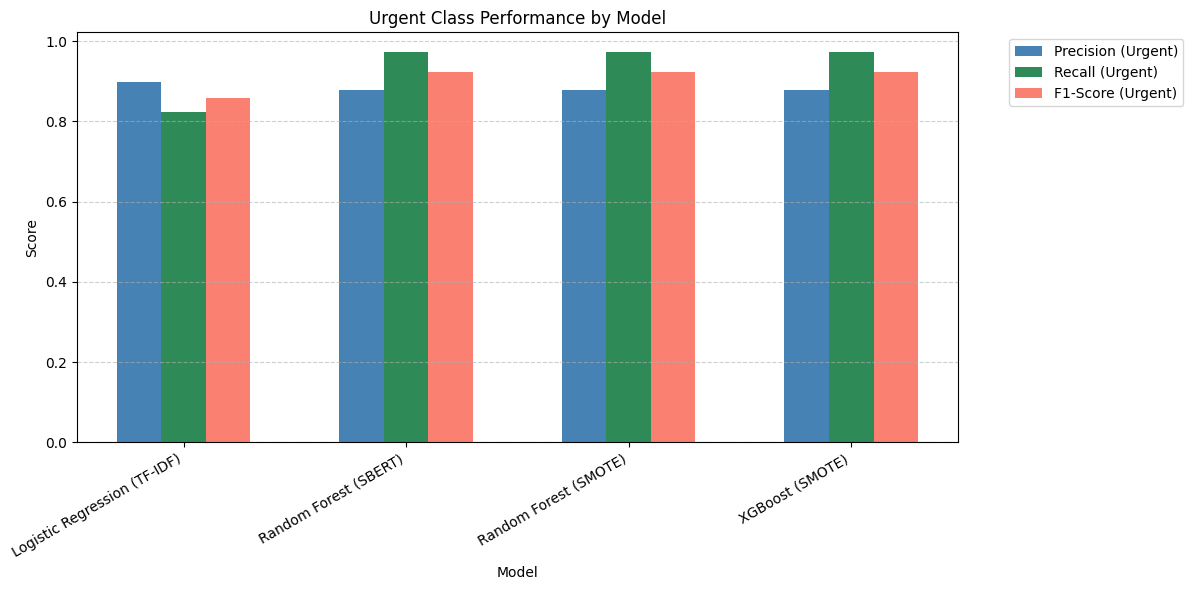

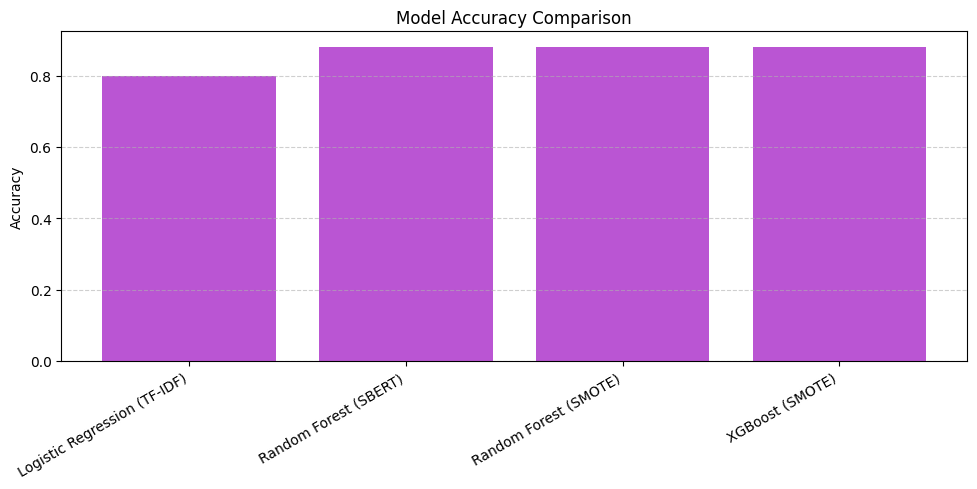

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load metrics and ensure unique models
df = pd.read_csv("metrics_summary.csv").drop_duplicates(subset='Model', keep='last')

# Bar positions
bar_width = 0.2
index = np.arange(len(df))

# Grouped bar chart for Precision, Recall, F1-Score
plt.figure(figsize=(12, 6))
plt.bar(index, df['Precision (Urgent)'], bar_width, label='Precision (Urgent)', color='steelblue')
plt.bar(index + bar_width, df['Recall (Urgent)'], bar_width, label='Recall (Urgent)', color='seagreen')
plt.bar(index + 2 * bar_width, df['F1-Score (Urgent)'], bar_width, label='F1-Score (Urgent)', color='salmon')

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Urgent Class Performance by Model')
plt.xticks(index + bar_width, df['Model'], rotation=30, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Accuracy bar plot
plt.figure(figsize=(10, 5))
plt.bar(df['Model'], df['Accuracy'], color='mediumorchid')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()
